In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
from os.path import join

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cross_validation as skcv

import datatools
from models import MeanModel, SimpleModel, StandardModel
from solver import Solver

In [8]:
amz_books_url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Books.csv'  # 22,507,155
amz_elec_url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Electronics.csv'  # 7,824,482
amz_vgames_url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Video_Games.csv'  # 1,324,753
amz_instr_url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Musical_Instruments.csv'  # 500,176

filename = datatools.cached_download(amz_instr_url)
unique_users, uid_map, unique_items, iid_map, X, y = datatools.parse_amazon_csv(filename, ',')
X = np.array(X)
y = np.array(y)

# cross validation split
# use random_state=42 for deterministic split
X_train, X_test, y_train, y_test = skcv.train_test_split(X, y, test_size=0.25)

len(unique_users), len(unique_items)


(339231, 83046)

In [9]:
nUsers = 1 + max(X_train[:, 0].max(), X_test[:, 0].max())
nItems = 1 + max(X_train[:, 1].max(), X_test[:, 1].max())
nUsers, nItems


(339231, 83046)

In [10]:
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_test,
    'y_val': y_test
}

In [11]:
model = SimpleModel(nUsers, nItems)
solver = Solver(model, data,
                update_rule='adam',
                optim_config={
                    'learning_rate': 1e-2,
                },
                lr_decay=0.9,
                num_epochs=10, batch_size=400,
                print_every=100)

In [277]:
solver.train()

In [13]:
plt.plot(solver.loss_history, 'o', alpha=0.7)
plt.ylim((0, 2))

(0, 2)

(0, 2)

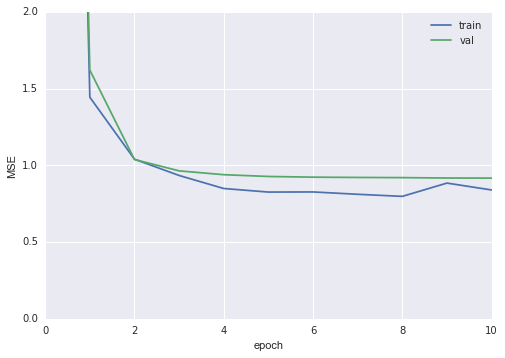

In [280]:
def plotTrainTest(solver):
    plt.plot(solver.train_loss_history, label='train')
    plt.plot(solver.val_loss_history, label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    
plotTrainTest(solver)
plt.ylim((0, 2))

In [282]:
mse, _ = model.loss(X_test, y_test, use_reg=False)
mse

0.91698193359375002

In [283]:
model2 = MeanModel()

In [284]:
model2.fit(y_train)

In [285]:
mse, _ = model2.loss(X_test, y_test)
mse

1.3309682617187499

In [311]:
model3 = StandardModel(nUsers, nItems, latentDim=10, reg=1e-3)
for p, v in model.params.items():
    model3.params[p] = v.copy()
    
solver3 = Solver(model3, data,
                update_rule='adam',
                optim_config={
                    'learning_rate': 3e-4,
                },
                lr_decay=1,
                num_epochs=10, batch_size=1000,
                print_every=100)
solver3.train()

(Iteration 1 / 800) loss: 0.808460
(Epoch 0 / 10) train loss: 0.838434; val_loss: 0.916975
(Epoch 1 / 10) train loss: 0.858059; val_loss: 0.916735
(Iteration 101 / 800) loss: 0.838795
(Epoch 2 / 10) train loss: 0.830463; val_loss: 0.916469
(Iteration 201 / 800) loss: 0.844670
(Epoch 3 / 10) train loss: 0.815777; val_loss: 0.916174
(Iteration 301 / 800) loss: 0.833526
(Epoch 4 / 10) train loss: 0.855147; val_loss: 0.916099
(Epoch 5 / 10) train loss: 0.864537; val_loss: 0.915930
(Iteration 401 / 800) loss: 0.824218
(Epoch 6 / 10) train loss: 0.823354; val_loss: 0.915782
(Iteration 501 / 800) loss: 0.866399
(Epoch 7 / 10) train loss: 0.830654; val_loss: 0.915585
(Iteration 601 / 800) loss: 0.821536
(Epoch 8 / 10) train loss: 0.812174; val_loss: 0.915558
(Iteration 701 / 800) loss: 0.790074
(Epoch 9 / 10) train loss: 0.837765; val_loss: 0.915514
(Epoch 10 / 10) train loss: 0.838459; val_loss: 0.915352


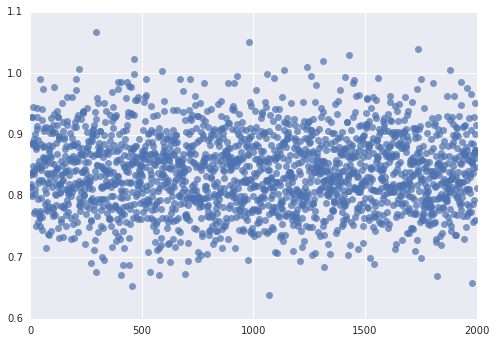

In [312]:
plt.plot(solver2.loss_history, 'o', alpha=0.7)

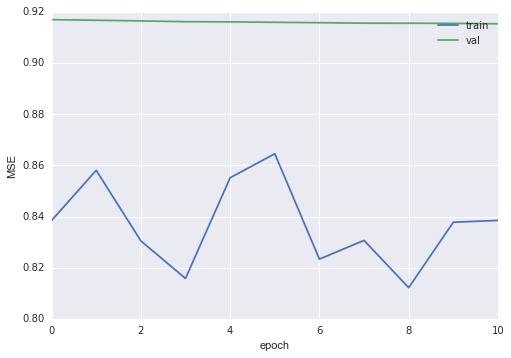

In [313]:
plotTrainTest(solver3)

In [307]:
mse, _ = model3.loss(X_test, y_test, use_reg=False)
mse

0.91460341796875